In this project we will use XGBoost model to see how accurate it is in detecting whether a transaction is a normal payment or a fraud. 

note:
1. the features are scaled except the and the Time and Amount column, other than that the features are not shown due to privacy reasons.
2. There are no "Null" values, so we don't have to work on ways to replace values.
3. Most of the transactions were Non-Fraud (99.83%) of the time, while Fraud transactions occurs (017%) of the time in the dataframe


# Import the required modul

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import xgboost as xgb
from sklearn.utils import resample
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
import warnings
warnings.filterwarnings("ignore")

# Data Preparation

In [11]:
df = pd.read_csv('credit_card.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [12]:
df.columns = df.columns.str.lower()

In [7]:
df.shape

(284807, 31)

In [5]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

# Ekploratory Data Analysis

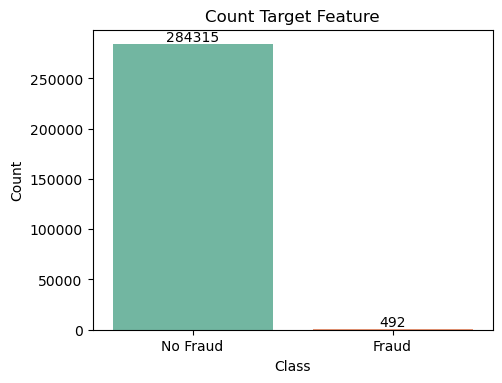

In [4]:
fig = plt.figure(figsize=(8,6), dpi= 100)
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.countplot(data=df, x='class', palette="Set2")

for c in ax.containers:
    ax.bar_label(c)

ax.set_title('Count Target Feature')
ax.set_xlabel('Class')
ax.set_ylabel('Count')
ax.set_xticklabels(['No Fraud', 'Fraud'])
plt.show()

from the count plot we can see that the target variabel were highly imbalanced, the '0' values or indicationg no fraud case and the '1' values indicating fraud case, there are many ways to deal with this imbalanced data such as undersampled, oversampled, or SMOTE technique.

1. First, we have to determine how imbalanced is our class to knowing the amount of each label
2. Once we determine how many instances are considered fraud transactions, in this case have a label '1', we should bring the non-fraud transactions to the same amount as fraud transactions (assuming we want to make 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.

In [24]:
fraud = df[df['class'] == 1]
no_fraud = df[df['class'] == 0]

no_fraud_undersampled = resample(
                            no_fraud,
                            n_samples = 492,
                            random_state = 42
)

df_new = pd.concat([no_fraud_undersampled, fraud])
df_new.shape

(984, 31)

Text(0.5, 1.0, 'Correlation of each features')

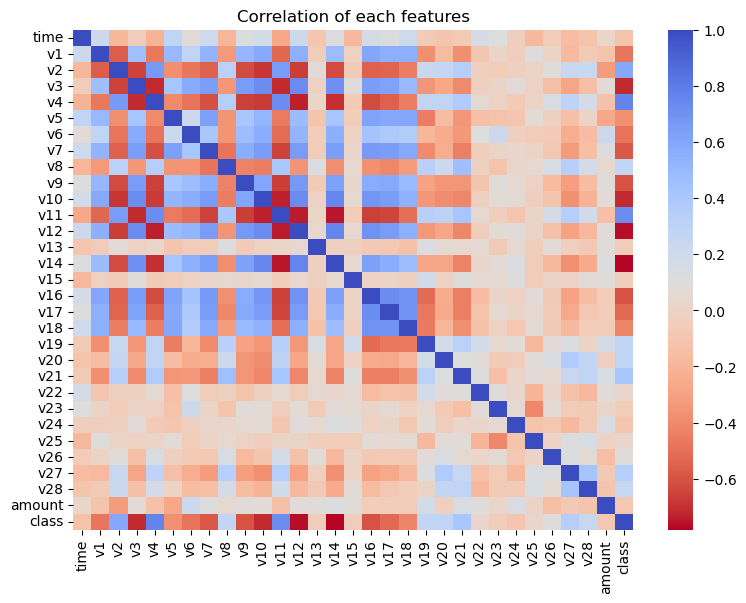

In [6]:
corr_df = df_new.corr(method='spearman')
fig = plt.figure(figsize=(14,10), dpi= 100)
ax = fig.add_axes([0.1, 0.1, 0.5, 0.5])
ax = sns.heatmap(corr_df, cmap='coolwarm_r')
ax.set_title('Correlation of each features')

from the correlation matrix, we can see that the features v2, v4, v11, and v21 have a positive correlation with correctly identify fraud case, in other word's. the increasing value of this feature can lead to the fraud transaction, other wise, the features v3, v12, and v14 have a negative correlation with correctly identify fraud case, or we can say that increasing value of this features inversely related to identify fraud. next we can plot the boxplot to see the distribution for each important features.

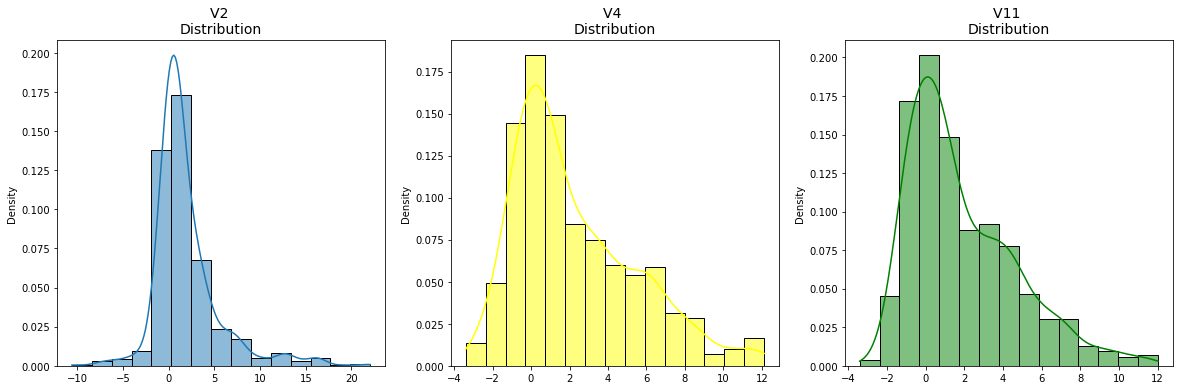

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

#fig.suptitle('Distribution of the positive correlation', fontsize=20)

sns.histplot(df_new, x='v2', bins= 15, kde=True, ax=ax[0], stat='density')
ax[0].set_title('V2 \nDistribution', fontsize=14)
ax[0].set_xlabel('')

sns.histplot(df_new, x='v4', bins= 15, kde=True, ax=ax[1], color='yellow', stat='density')
ax[1].set_title('V4 \nDistribution', fontsize=14)
ax[1].set_xlabel('')

sns.histplot(df_new, x='v11', bins= 15, kde=True, ax=ax[2], color='green', stat='density')
ax[2].set_title('V11 \nDistribution', fontsize=14)
ax[2].set_xlabel('')

plt.show()

From the histplot above we can see that the distribution of each features on the positive correlation's feature were positively skewed. On the positively skewed data the majority of the data lie under the value of the mean

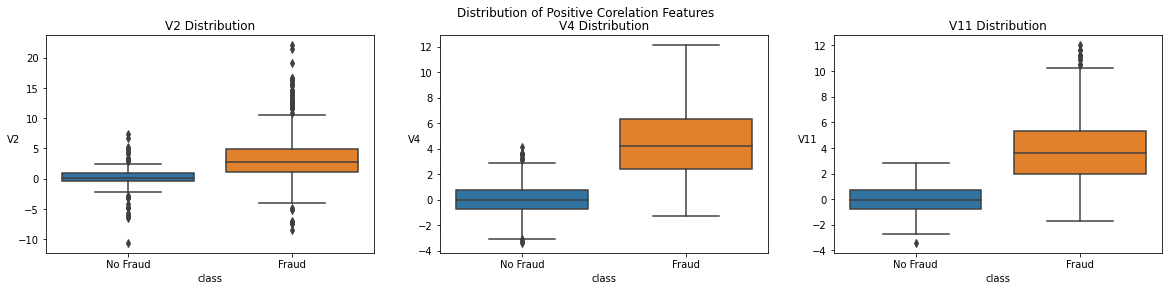

In [7]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

fig.suptitle('Distribution of Positive Corelation Features')

sns.boxplot(y ='v2', data=df_new, x='class', ax=ax[0])
ax[0].set_title('V2 Distribution')
ax[0].set_ylabel('V2', rotation= 0)
ax[0].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

sns.boxplot(y ='v4', data=df_new, x='class', ax=ax[1])
ax[1].set_title('V4 Distribution')
ax[1].set_ylabel('V4', rotation= 0)
ax[1].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

sns.boxplot(y ='v11', data=df_new, x='class', ax=ax[2])
ax[2].set_title('V11 Distribution')
ax[2].set_ylabel('V11', rotation= 0)
ax[2].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

plt.show()

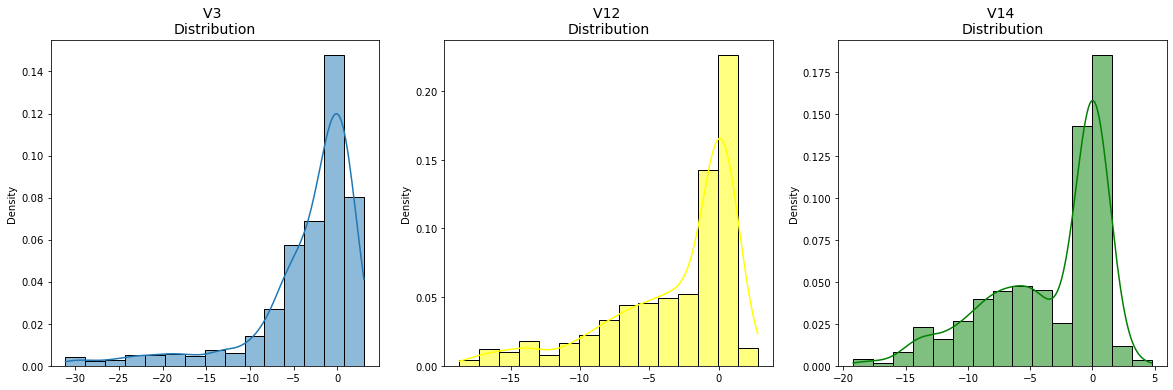

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(20,6))

#fig.suptitle('Distribution of the positive correlation', fontsize=20)

sns.histplot(df_new, x='v3', bins= 15, kde=True, ax=ax[0], stat='density')
ax[0].set_title('V3 \nDistribution', fontsize=14)
ax[0].set_xlabel('')

sns.histplot(df_new, x='v12', bins= 15, kde=True, ax=ax[1], color='yellow', stat='density')
ax[1].set_title('V12 \nDistribution', fontsize=14)
ax[1].set_xlabel('')

sns.histplot(df_new, x='v14', bins= 15, kde=True, ax=ax[2], color='green', stat='density')
ax[2].set_title('V14 \nDistribution', fontsize=14)
ax[2].set_xlabel('')

plt.show()

From the histplot above we can see that each features on the negative correlation's feature were negatively skewed. In other word, the majority of the data lie above the value of the mean

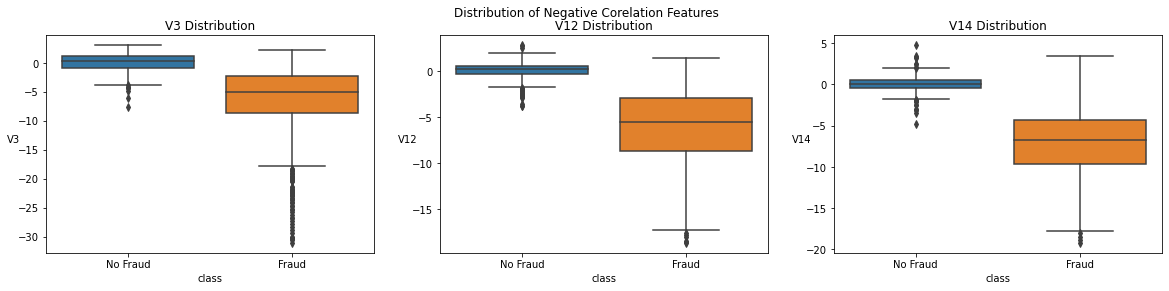

In [100]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,4))

fig.suptitle('Distribution of Negative Corelation Features')

sns.boxplot(y ='v3', data=df_new, x='class', ax=ax[0])
ax[0].set_title('V3 Distribution')
ax[0].set_ylabel('V3', rotation= 0)
ax[0].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

sns.boxplot(y ='v12', data=df_new, x='class', ax=ax[1])
ax[1].set_title('V12 Distribution')
ax[1].set_ylabel('V12', rotation= 0)
ax[1].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

sns.boxplot(y ='v14', data=df_new, x='class', ax=ax[2])
ax[2].set_title('V14 Distribution')
ax[2].set_ylabel('V14', rotation= 0)
ax[2].set_xticklabels(['No Fraud', 'Fraud'], rotation= 0)

plt.show()

Same with the positive correlation boxplot, we can find some outliers in the features especially in the fraud case, this outlier can decrease our model performance if we doest treat it, there some ways to deals with this situation such as replacing the outliers with the median of the features or also we can remove the data that contain the outliers if the amount of outliers within the data is relatively small. but in this case, since i use the XG boost model, it doest need to treat the outliers because XGBoost were robust or not affected by outliers. so we can easily go to the next step of our analysis

# Build the preliminary model

In [13]:
X = df.drop('class', axis= 1)
y = df['class']

In this section we separate the dependent (class) and independent variabel, and split the data into 75 % for the training data and 25 % for the test data 

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state= 42)

In [39]:
ns = NearMiss(0.3)

X_train_ns, y_train_ns = ns.fit_resample(X_train, y_train)

print('before : {}'.format(Counter(y_train)))
print('after : {}'.format(Counter(y_train_ns)))

before : Counter({0: 213226, 1: 379})
after : Counter({0: 1263, 1: 379})


In this section we building the preliminary model with the undersampled data, setting evaluation metric to 'aucpr' or the score from the ratio of the true positive and false positive, i used this evaluation metric because in this case classifying the fraud case is more important than classifying the no fraud case, i set the early stopping rounds to 10, it means that the model will check the validation score every 10 trees that the model's were made, if the validation score were not improve it will stop to creating more trees. Also i set the eval_set to test data to evaluate the performance of the model during training, it will be used to report model performance as the training goes

In [53]:
xg_clf = xgb.XGBClassifier(objective='binary:logistic', seed=42)
xg_clf.fit(X_train_ns, y_train_ns,
           verbose=True,
           eval_metric='aucpr',
           early_stopping_rounds= 10,
           eval_set = [(X_test, y_test)] 
           )

[0]	validation_0-aucpr:0.25832
[1]	validation_0-aucpr:0.46964
[2]	validation_0-aucpr:0.53407
[3]	validation_0-aucpr:0.53375
[4]	validation_0-aucpr:0.53395
[5]	validation_0-aucpr:0.58913
[6]	validation_0-aucpr:0.59829
[7]	validation_0-aucpr:0.56513
[8]	validation_0-aucpr:0.59411
[9]	validation_0-aucpr:0.59197
[10]	validation_0-aucpr:0.62816
[11]	validation_0-aucpr:0.61841
[12]	validation_0-aucpr:0.65041
[13]	validation_0-aucpr:0.66240
[14]	validation_0-aucpr:0.66572
[15]	validation_0-aucpr:0.65793
[16]	validation_0-aucpr:0.63487
[17]	validation_0-aucpr:0.59832
[18]	validation_0-aucpr:0.59736
[19]	validation_0-aucpr:0.64689
[20]	validation_0-aucpr:0.64912
[21]	validation_0-aucpr:0.66360
[22]	validation_0-aucpr:0.66351
[23]	validation_0-aucpr:0.66343
[24]	validation_0-aucpr:0.65978


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

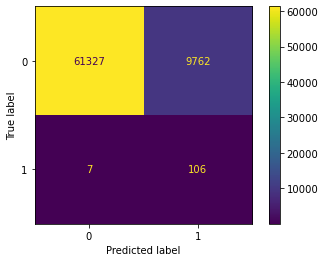

In [44]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xg_clf,
                     X_test,
                     y_test)

From the confusion matrix of our preliminary model of XGBoost, we can see that in 71089 of transsaction were no fraud, 60702 (85.4 %) were correctly classified. And in the 120 case that were fraud, 107 (94.6 %) were correctly classified. in order to improve our model to correctly classified the fraud, we can do cross validation and hyperparameter tuning to optimize the parameter

# Optimize the model

In [54]:
from sklearn.model_selection import GridSearchCV

params = {
        'max_depth': [3, 4, 6],
        'learning_rate': [1, 0.1, 0.3],
        'gamma': [0, 0.25, 1.0],
        'reg_lambda': [0, 1.0, 10.0],
        'colsample_bytree':[0.6, 0.8, 1],
        'min_child_weight':[1, 3]
}

optimal_params = GridSearchCV(estimator=xgb.XGBClassifier(objective='binary:logistic',
                                                         ), 
                param_grid = params,
                scoring = 'roc_auc',
                verbose= 2,
                n_jobs = 10,
                cv = 3)

optimal_params.fit(X_train_ns, y_train_ns)
print('Best Params : {}'.format(optimal_params.best_params_))
print('Best CV Score : {}'.format(optimal_params.best_score_))

Fitting 3 folds for each of 486 candidates, totalling 1458 fits
[00:25:54] WARNING: D:\bld\xgboost-split_1645118015404\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best Params : {'colsample_bytree': 0.6, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'reg_lambda': 1.0}
Best CV Score : 0.9949746483589789


In [55]:
xg_clf = xgb.XGBClassifier(objective='binary:logistic', gamma= 0, learning_rate= 0.3, 
                           max_depth= 3, reg_lambda= 10, colsample_bytree= 0.6, min_child_weight= 1,
                           seed=42)
xg_clf.fit(X_train_ns, y_train_ns,
           verbose=True,
           eval_metric='aucpr',
           early_stopping_rounds= 10,
           eval_set = [(X_test, y_test)] 
           )

[0]	validation_0-aucpr:0.22291
[1]	validation_0-aucpr:0.65087
[2]	validation_0-aucpr:0.70352
[3]	validation_0-aucpr:0.70541
[4]	validation_0-aucpr:0.71981
[5]	validation_0-aucpr:0.70198
[6]	validation_0-aucpr:0.70657
[7]	validation_0-aucpr:0.70109
[8]	validation_0-aucpr:0.69639
[9]	validation_0-aucpr:0.68634
[10]	validation_0-aucpr:0.68841
[11]	validation_0-aucpr:0.68998
[12]	validation_0-aucpr:0.76626
[13]	validation_0-aucpr:0.76417
[14]	validation_0-aucpr:0.76683
[15]	validation_0-aucpr:0.76626
[16]	validation_0-aucpr:0.76919
[17]	validation_0-aucpr:0.77159
[18]	validation_0-aucpr:0.76995
[19]	validation_0-aucpr:0.76939
[20]	validation_0-aucpr:0.77135
[21]	validation_0-aucpr:0.76716
[22]	validation_0-aucpr:0.76475
[23]	validation_0-aucpr:0.76861
[24]	validation_0-aucpr:0.77015
[25]	validation_0-aucpr:0.77266
[26]	validation_0-aucpr:0.76425
[27]	validation_0-aucpr:0.76041
[28]	validation_0-aucpr:0.76061
[29]	validation_0-aucpr:0.75471
[30]	validation_0-aucpr:0.74850
[31]	validation_0-

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=10, scale_pos_weight=1,
              seed=42, subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

# Build the final model

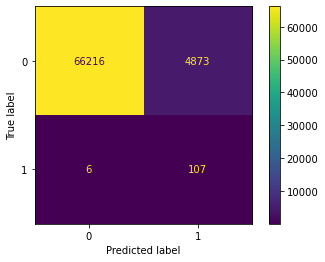

In [56]:
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xg_clf,
                     X_test,
                     y_test)

In this optimized model we can see that the XG boost model is slighthly improve identifying the tranksaction that were fraud, 107 (94.7 %) and also improving the correctly identify no fraud case to 66216 (93.1 %). 